1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли p-value меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли p-value меньше?

Импорт библиотек и подготовка данных

In [1]:
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620.feed_actions'}

In [3]:
# Загрузка данных
q_1_2 = '''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions
WHERE toDate(time) between '2022-05-25' and '2022-05-30'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
'''

q_0_3 = '''
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions
WHERE toDate(time) between '2022-05-25' and '2022-05-30'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
'''

In [4]:
df_group_1_2 = pandahouse.read_clickhouse(q_1_2, connection=connection)
df_group_0_3 = pandahouse.read_clickhouse(q_0_3, connection=connection)

In [5]:
 # Расчёт глобального CTR для контрольных групп
ctr_control_0 = df_group_0_3.query('exp_group == 0')['likes'].sum() / df_group_0_3.query('exp_group == 0')[
    'views'].sum()
ctr_control_1 = df_group_1_2.query('exp_group == 1')['likes'].sum() / df_group_1_2.query('exp_group == 1')[
    'views'].sum()

In [6]:
ctr_control_0, ctr_control_1

(0.20739241639165873, 0.20736316358580917)

In [7]:
def get_linearized_likes(likes, global_ctr, views):
    linearized_likes = likes - global_ctr * views
    return linearized_likes

In [8]:
df_group_0_3['linearized_likes'] = df_group_0_3.apply(lambda x: get_linearized_likes(x.likes, x.views, ctr_control_0), axis=1)
df_group_1_2['linearized_likes'] = df_group_1_2.apply(lambda x: get_linearized_likes(x.likes, x.views, ctr_control_1), axis=1)

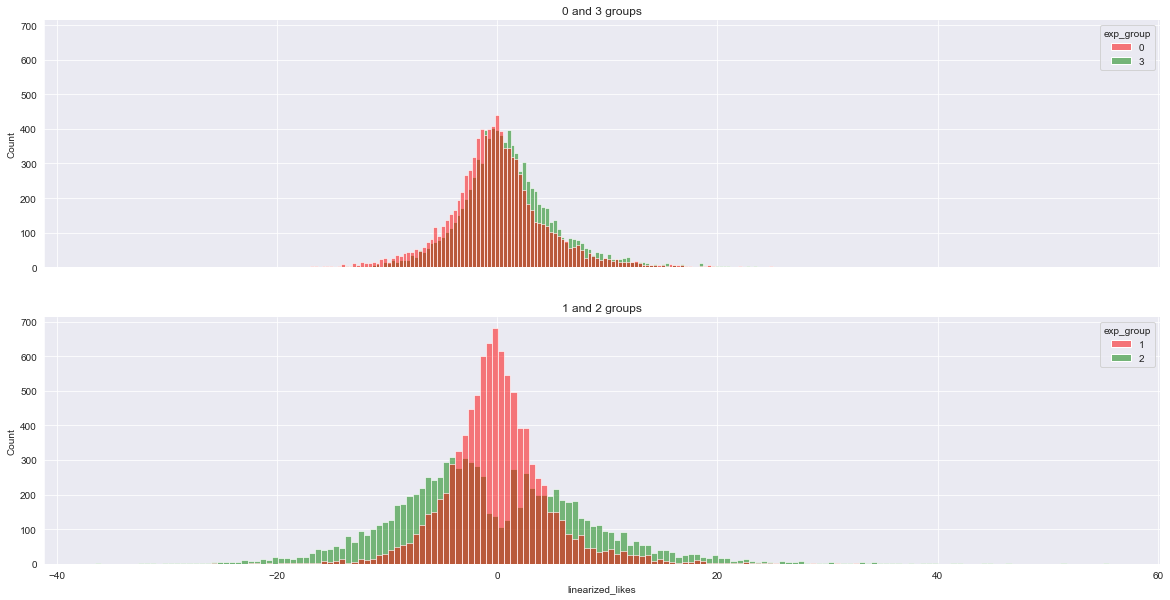

In [9]:
# Оценим распределения визуально
fig, axes = plt.subplots(2, figsize=(20, 10), sharex='all', sharey='all')

axes[0] = sns.histplot(data=df_group_0_3,
                       x='linearized_likes',
                       hue='exp_group',
                       alpha=0.5,
                       palette=['r', 'g'],
                       ax=axes[0])

axes[1] = sns.histplot(data=df_group_1_2,
                       x='linearized_likes',
                       hue='exp_group',
                       alpha=0.5,
                       palette=['r', 'g'],
                       ax=axes[1])

axes[0].set_title('0 and 3 groups')
axes[1].set_title('1 and 2 groups')

sns.despine()

Проведение тестирования
Для сравнения значений проведём 3 теста: CTR без изменений, сглаженный CTR и линеаризованный CTR.

In [10]:
df_group_0_3['ctr'] = df_group_0_3.likes / df_group_0_3.views
df_group_1_2['ctr'] = df_group_1_2.likes / df_group_1_2.views

In [11]:
global_ctr_0_3 = df_group_0_3.likes.sum() / df_group_0_3.views.sum()
global_ctr_1_2 = df_group_1_2.likes.sum() / df_group_1_2.views.sum()

In [12]:
def get_smoothed_ctr(views, likes, global_ctr, alpha=5):
    smoothed_ctr = (likes - global_ctr * alpha) / (views + alpha)
    return smoothed_ctr

In [13]:
df_group_0_3['smoothed_ctr'] = df_group_0_3.apply(lambda x: get_smoothed_ctr(x.views, x.likes, global_ctr_0_3), axis=1)
df_group_1_2['smoothed_ctr'] = df_group_1_2.apply(lambda x: get_smoothed_ctr(x.views, x.likes, global_ctr_1_2), axis=1)

In [14]:
# CTR
ttest_0_3_ctr = ttest_ind(df_group_0_3.query('exp_group == 0').ctr,
                          df_group_0_3.query('exp_group == 3').ctr,
                          equal_var=False)[1]
ttest_1_2_ctr = ttest_ind(df_group_1_2.query('exp_group == 1').ctr,
                          df_group_1_2.query('exp_group == 2').ctr,
                          equal_var=False)[1]

In [15]:
# Сглаженный CTR
ttest_0_3_smoothed_ctr = ttest_ind(df_group_0_3.query('exp_group == 0').smoothed_ctr,
                                   df_group_0_3.query('exp_group == 3').smoothed_ctr,
                                   equal_var=False)[1]
ttest_1_2_smoothed_ctr = ttest_ind(df_group_1_2.query('exp_group == 1').smoothed_ctr,
                                   df_group_1_2.query('exp_group == 2').smoothed_ctr,
                                   equal_var=False)[1]

In [16]:
# Линеаризованный CTR
ttest_0_3_linearized_ctr = ttest_ind(df_group_0_3.query('exp_group == 0').linearized_likes,
                                     df_group_0_3.query('exp_group == 3').linearized_likes,
                                     equal_var=False)[1]
ttest_1_2_linearized_ctr = ttest_ind(df_group_1_2.query('exp_group == 1').linearized_likes,
                                     df_group_1_2.query('exp_group == 2').linearized_likes,
                                     equal_var=False)[1]

In [17]:
print(f'CTR p-value {ttest_0_3_ctr, ttest_1_2_ctr}')
print(f'Smoothed CTR p-value {ttest_0_3_smoothed_ctr, ttest_1_2_smoothed_ctr}')
print(f'Linearized CTR p-value {ttest_0_3_linearized_ctr, ttest_1_2_linearized_ctr}')

CTR p_value (2.8790344485501777e-40, 0.2962607309001455)
Smoothed CTR p_value (9.738656481745686e-37, 0.05747390647581783)
Linearized CTR p_value (4.077289882378915e-47, 4.2066534734104125e-08)


**Итоги**

Использование "поюзерных" метрик-отношений без какого-либо преобразования может исказить результаты A/B тестов, так как не учитываются абсолютные значения для каждого юзера.
Чтобы увеличить чувствительность теста, следует преобразовать подобные метрики: например, используя сглаживание или линеаризацию.